# Goal here: understand what the optimiser is doing 
 - fit a 1d power law (cannot vary beta)
 - fit a 2d power law with fixed beta across the sky.
 
Make sure that you're generating the data the same way you're generating the models

In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


# Parameters for generating the map

In [3]:
nside = 128
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 5)*1.e9

In [4]:
#create a filepath to store different power spectra
filepath = '/Users/alex/Documents/foreground_moments/power_spectra'

# Try a 2d fit on $(A, \alpha)$ with a constant $\beta$ across the sky.
In this case the model is from the same as the 0x0 term with the same parameters

In [5]:
params = [A, alpha]

In [6]:
#define a function that generates a powerspectrum with constant beta across the sky
def PS_const(ells, freqs, params):
    A, alpha = params
    newmaps = ff.map_full_const(ells, freqs, params)
    #generates an amp map with powerlaw, and then SED using the default beta
    power_spectrum = np.zeros((len(freqs),len(ells)))
    for i in range(len(freqs)):
        power_spectrum[i] = hp.anafast(newmaps[i])
    return power_spectrum

In [7]:
#define the objective function that we wish to minimize (2d)
def chi2(params, ells, freqs, data):
    A, alpha = params
    #generate a model of the data from the parameters
    model = ff.auto0x0(freqs, ell_max=len(ells), A=A, alpha=alpha)
    resid = (data[:,2:] - model[:,2:])**2
    #define the cosmic variance part
    var = np.array([2*model[:,i]**2/(2*i+1) for i in range(2,len(ells))]).T 
    return np.sum(resid/var)

In [8]:
#define a reference powerspectrum
# PS_2d_const = PS_const(ells, freqs, params)
# save(filepath+'PS_2d_const', PS_2d_const)

In [9]:
# #define a mean reference powerspectrum
# N = 100
# big_mat = np.zeros((N,len(freqs),len(ells)))
# for i in range(N):
#     PS = PS_const(ells, freqs, params)
#     big_mat[i,...] = PS
# PS_mean = np.mean(big_mat, 0)
# save(filepath + 'PS_2d_const_mean.npy', PS_mean)

In [10]:
#load in the data
PS_2d_const = load(filepath + 'PS_2d_const.npy')
PS_2d_const_mean = load(filepath + 'PS_2d_const_mean.npy')

In [11]:
#define the relevant model, in this case the 0x0 moment with the same parameters
input_model = ff.auto0x0(freqs, ell_max=len(ells), A=A, alpha=alpha)

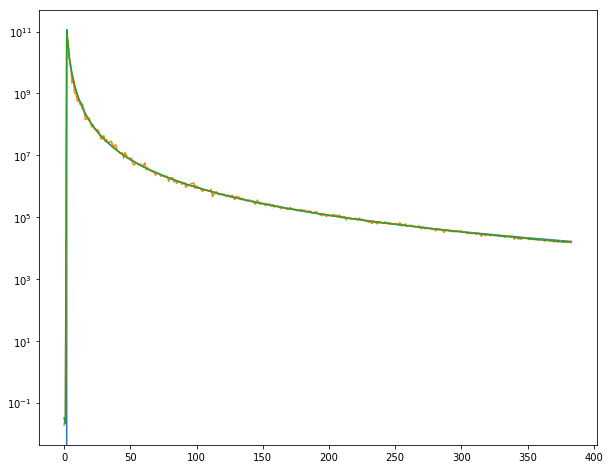

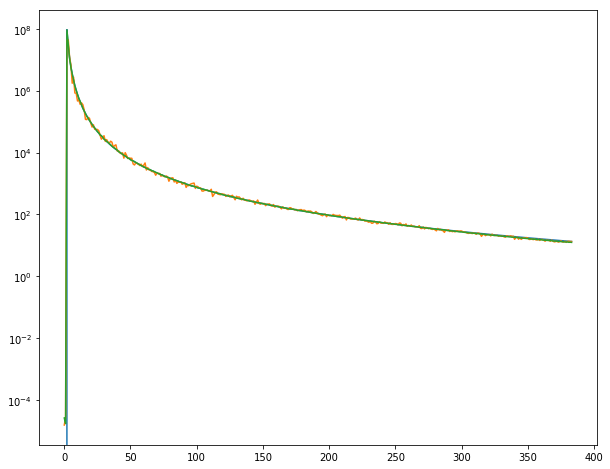

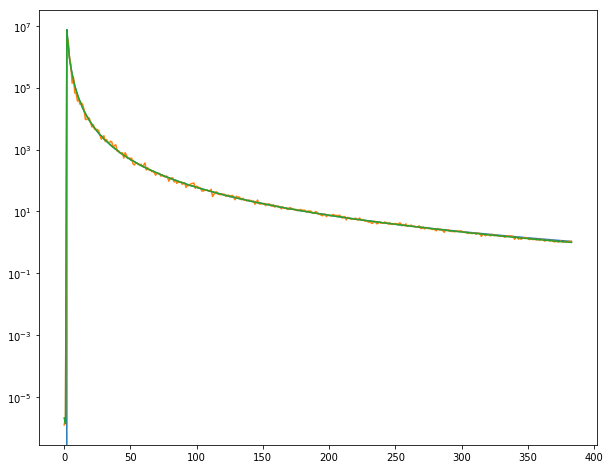

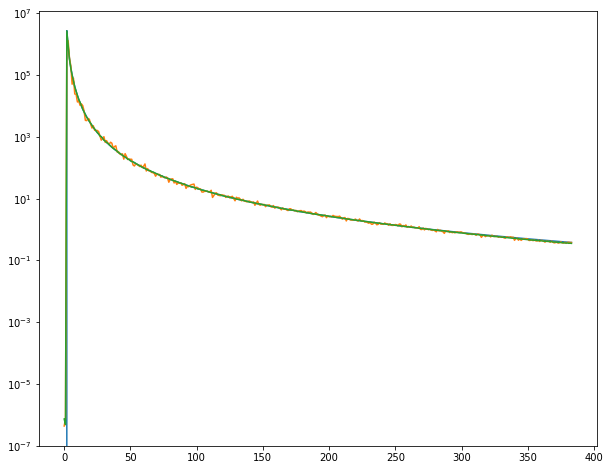

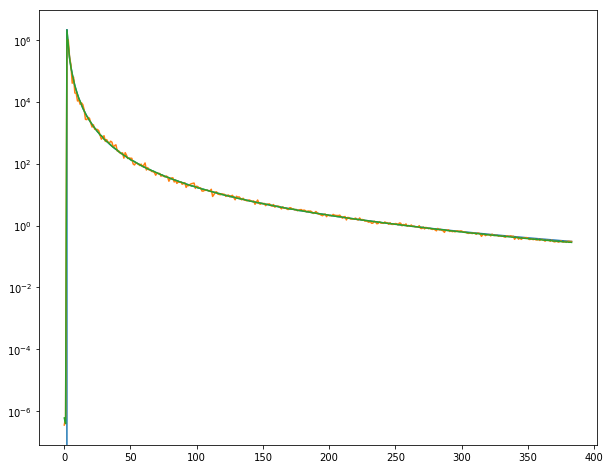

In [12]:
#check that these line up
for i in range(len(freqs)):
    figure(figsize=(10,8))
    semilogy(input_model[i])
    semilogy(PS_2d_const[i])
    semilogy(PS_2d_const_mean[i])

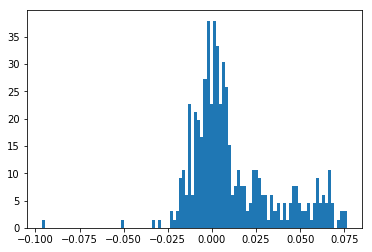

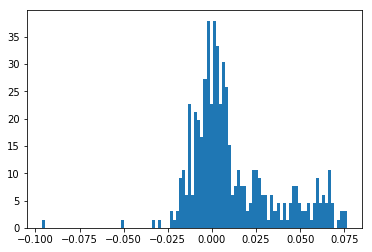

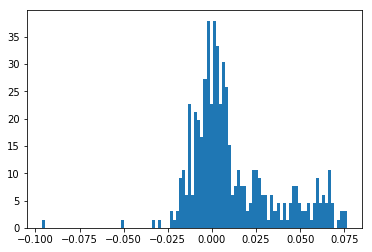

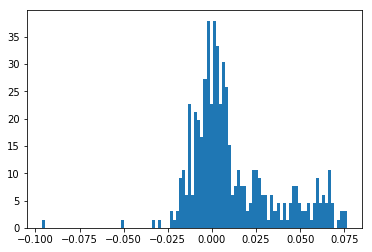

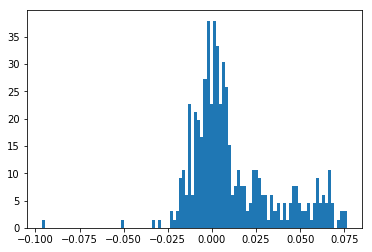

In [13]:
#good, check residuals
for i in range(len(freqs)):
    figure()
    hist((input_model[i][2:]-PS_2d_const_mean[i][2:])/input_model[i][2:], bins=100, density=True)
#     xlim(-1e6,1e6)

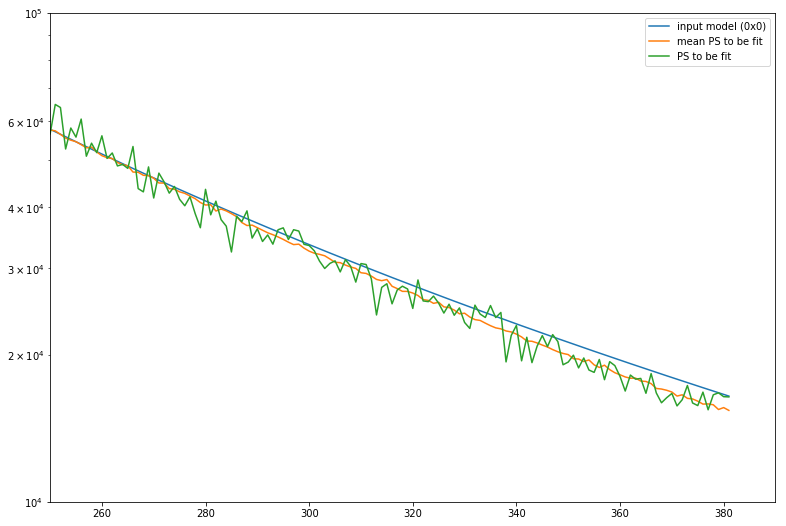

In [14]:
figure(figsize=(13,9))
semilogy(input_model[0][2:], label='input model (0x0)')
semilogy(PS_2d_const_mean[0][2:], label='mean PS to be fit')
semilogy(PS_2d_const[0][2:], label='PS to be fit')
xlim(250,390)
ylim(1e4,1e5)
legend();

In [15]:
#so appears that divergence between the input model and the auto0x0 is only at high ell, and this will be because
#of finite cut off and less power in the actual spectrum there, not predicted by the auto0x0

In [16]:
#okay, let's try a 2d fit with this then

In [17]:
start=time.time()
result0 = minimize(chi2, [1e3, -1], args=(ells, freqs, PS_2d_const))
print(time.time()-start)
print(result0)

0.310931921005249
      fun: 1903.3541154558338
 hess_inv: array([[ 6.81227248e-03, -1.67314927e-06],
       [-1.67314927e-06,  1.35050525e-06]])
      jac: array([0.        , 0.00186157])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 141
      nit: 25
     njev: 35
   status: 2
  success: False
        x: array([1769.33735643,   -3.05184356])


In [18]:
resultstart=time.time()
result1 = minimize(chi2, [1e3, -1], args=(ells, freqs, PS_2d_const_mean))
print(time.time()-start)
print(result1)

4.651535987854004
      fun: 158.54454735231286
 hess_inv: array([[ 8.96052702e-05, -2.36466848e-05],
       [-2.36466848e-05,  6.41275310e-06]])
      jac: array([-1.90734863e-06,  2.95639038e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 420
      nit: 29
     njev: 102
   status: 2
  success: False
        x: array([1728.20385763,   -3.03539838])


In [19]:
x0=result0.x
x1=result1.x
fit0 = ff.auto0x0(freqs, A=x0[0], alpha=x0[1])
fit1 = ff.auto0x0(freqs, A=x1[0], alpha=x1[1])

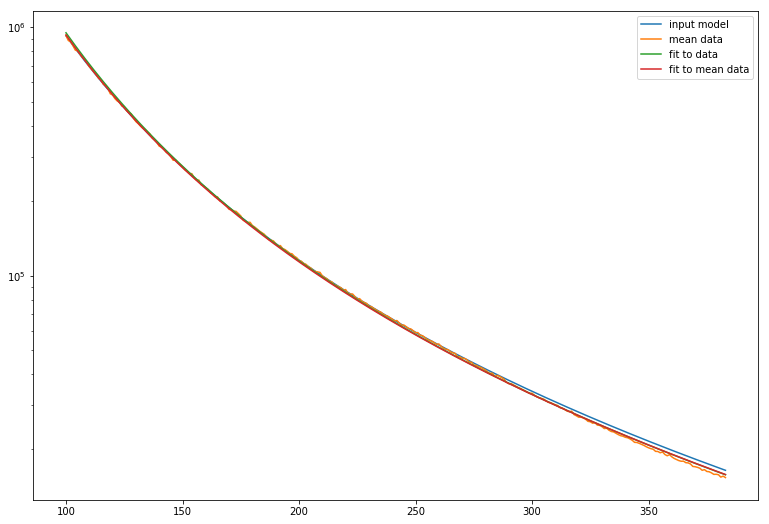

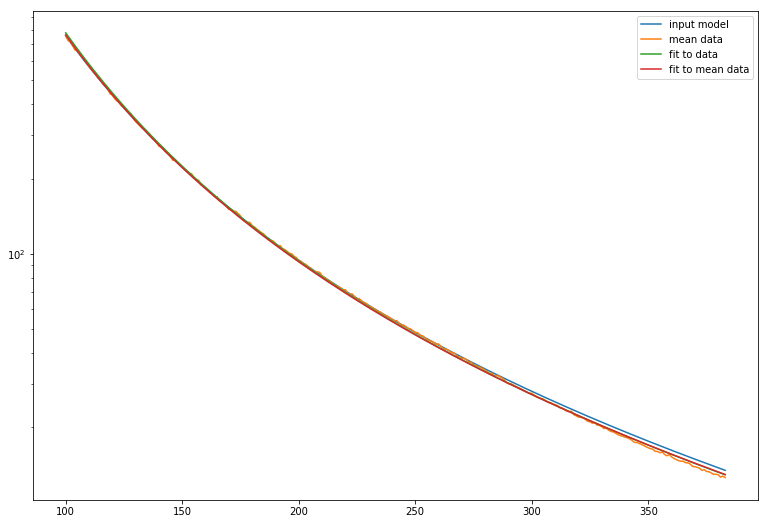

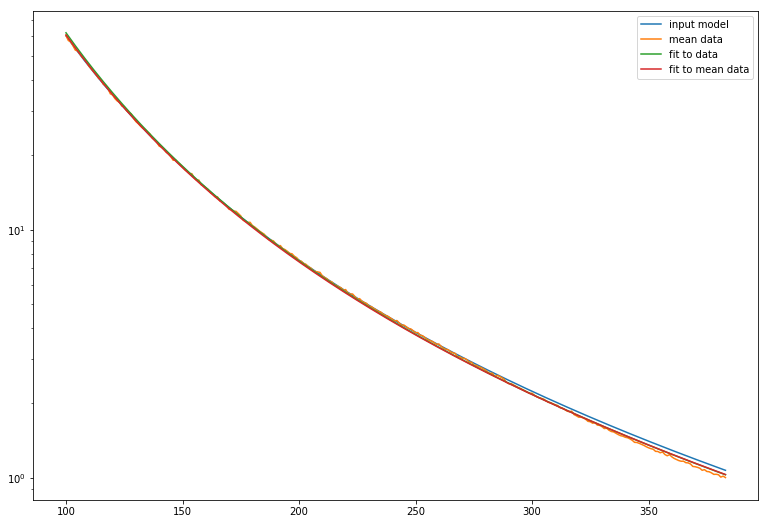

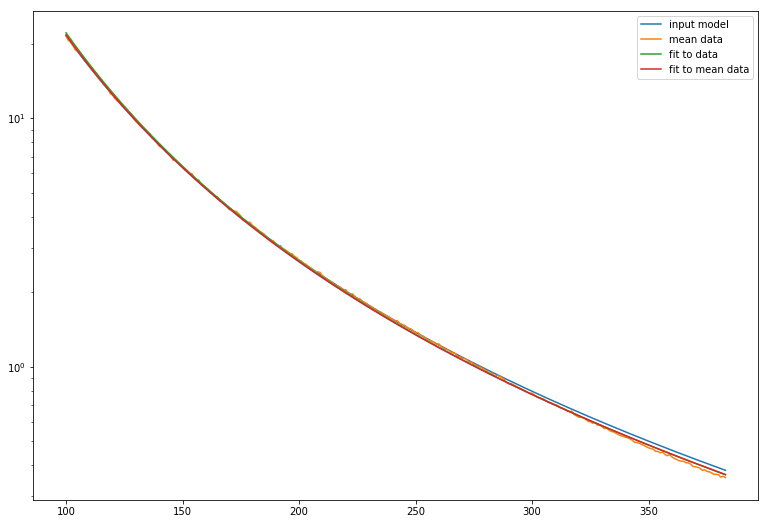

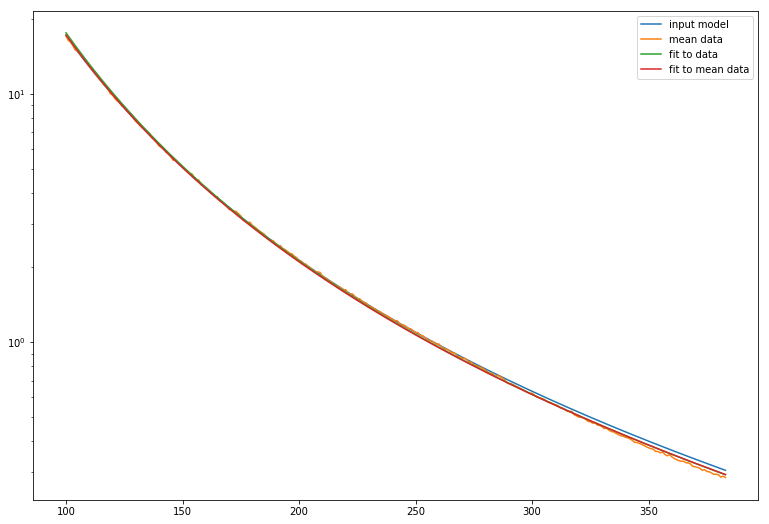

In [20]:
for i in range(len(freqs)):
    figure(figsize=(13,9))
    semilogy(ells[100:390], input_model[i][100:390], label='input model')
#     semilogy(ells[100:390], PS_2d_const[i][100:390], label='data')
    semilogy(ells[100:390], PS_2d_const_mean[i][100:390], label='mean data')
    semilogy(ells[100:390], fit0[i][100:390], label='fit to data')
    semilogy(ells[100:390], fit1[i][100:390], label='fit to mean data')
#     xlim(100,390)
    legend()

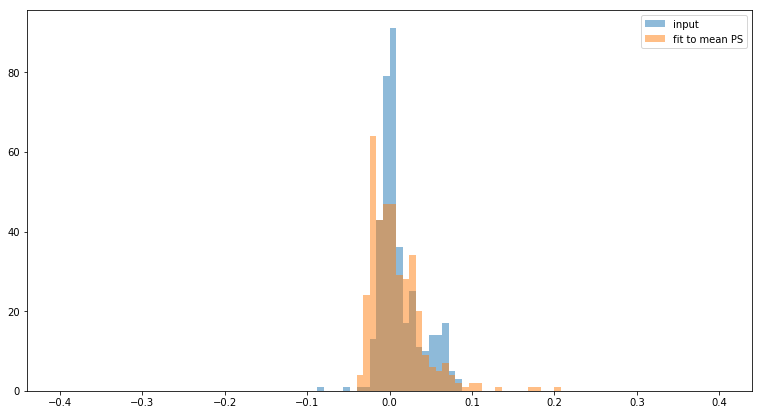

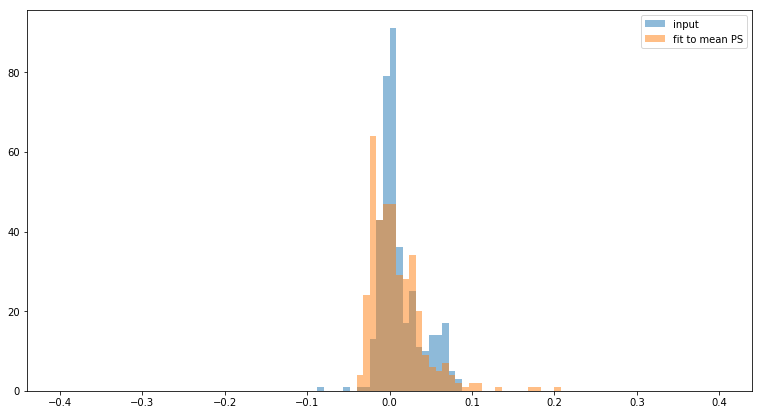

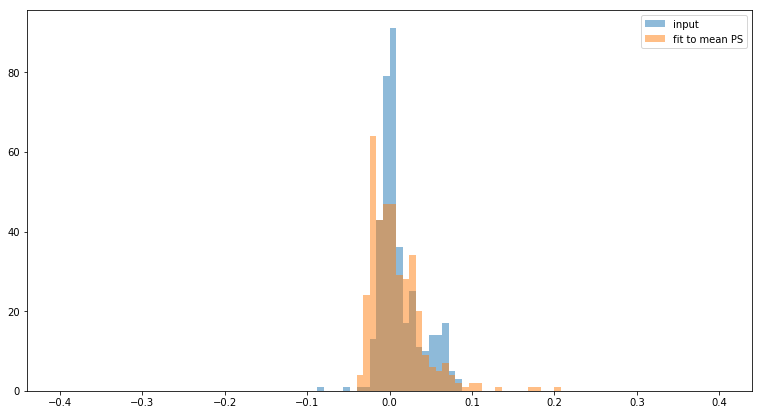

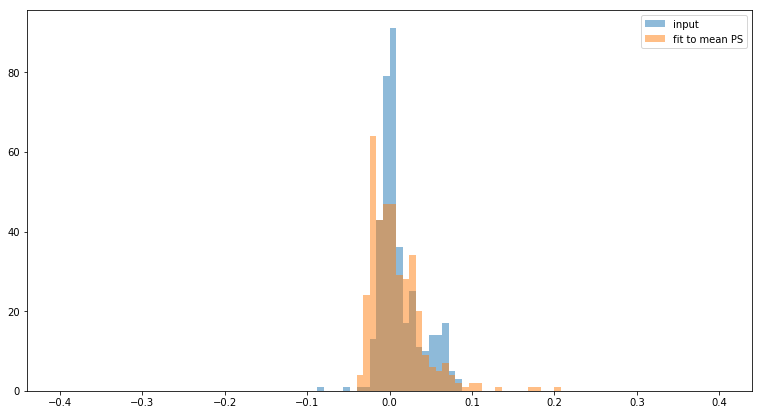

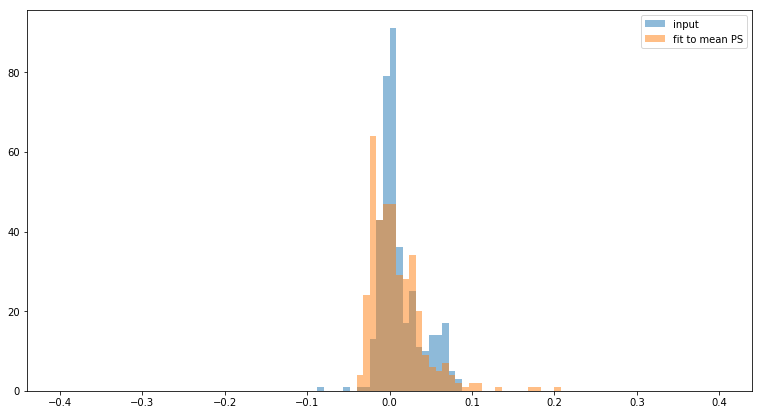

In [27]:
#plot histograms of the relative errors for these different fits
for i in range(len(freqs)):
    figure(figsize=(13,7))
    #input and data
    hist((input_model[i]-PS_2d_const_mean[i])/PS_2d_const_mean[i], label='input', alpha=0.5, bins=100,  range=(-0.4,0.4))
    #fit to realisation
#     hist((fit0[i]-PS_2d_const_mean[i])/PS_2d_const_mean[i], label='fit to realisation', alpha=0.5, bins=250, range=(-0.4,0.4))
    #fit to mean
    hist((fit1[i]-PS_2d_const_mean[i])/PS_2d_const_mean[i], label='fit to mean PS', alpha=0.5, bins=100, range=(-0.4,0.4))
    legend()

In [28]:
#possible the skewness is due to the natural drop off at high ell, causes over estimation?

# Okay, so the 2d fits for $(A, \alpha)$ are working (up to skewness?) in case of fixed $\beta$.
Can we do a 2d fit for $(A, \alpha, \beta)$?

In [29]:
%autoreload

In [30]:
#define a function that generates a powerspectrum with constant beta across the sky
def PS_const_beta(ells, freqs, params):
    A, alpha, beta = params
    newmaps = ff.map_full_const_beta(ells, freqs, params)
    power_spectrum = np.zeros((len(freqs),len(ells)))
    for i in range(len(freqs)):
        power_spectrum[i] = hp.anafast(newmaps[i])
    return power_spectrum

In [31]:
#define a new objective function
#define the objective function that we wish to minimize (2d)
def chi2_beta(params, ells, freqs, data):
    A, alpha, beta = params
    #generate a model of the data from the parameters
    model = ff.auto0x0(freqs, ell_max=len(ells), A=A, alpha=alpha, beta=beta)
    resid = (data[:,2:] - model[:,2:])**2
    #define the cosmic variance part
    var = np.array([2*model[:,i]**2/(2*i+1) for i in range(2,len(ells))]).T 
    return np.sum(resid/var)

In [32]:
#can use the same data as before

In [35]:
#default unbounded gets angry
#L-BFGS-B workds, 0.5 sec
#TNC also doesn't crash, but requires putting up the maximum number of iterations (slower than L-BFGS-B), 1.8 sec
#SLSQP is fast 0.4 sec and works, though throws up an error message about division by 0
start=time.time()
result2 = minimize(chi2_beta, [1e3, -1, -1], args=(ells, freqs, PS_2d_const_mean),
                  method='L-BFGS-B', options={'maxiter':1000})
print(time.time()-start)
print(result2)

0.4388999938964844
      fun: 158.54454735342597
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.84217094e-06, -1.63140612e-03, -2.29363195e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 196
      nit: 42
   status: 0
  success: True
        x: array([1728.20408272,   -3.03539847,   -3.20000001])


In [140]:
#good!

In [36]:
x2=result2.x
fit2 =  ff.auto0x0(freqs, A=x2[0], alpha=x2[1], beta=x2[2])

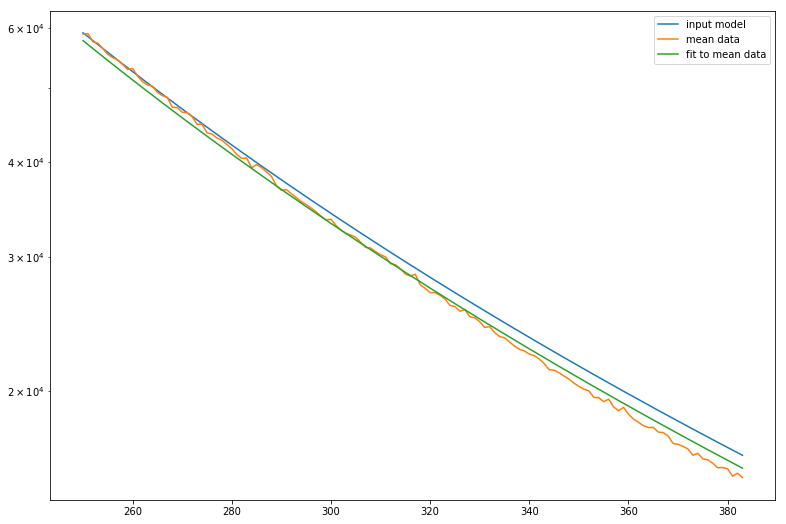

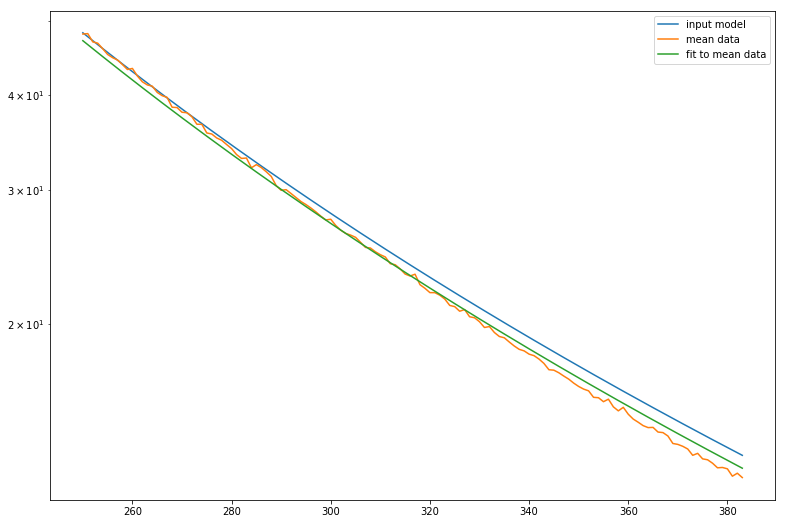

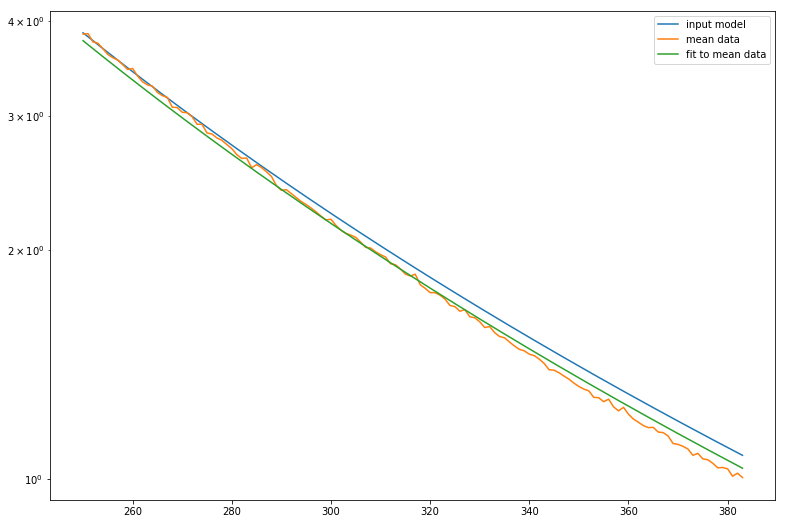

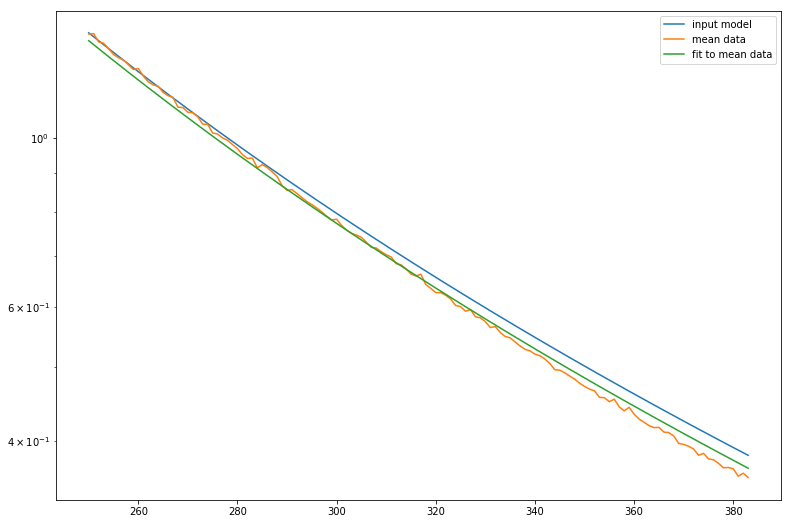

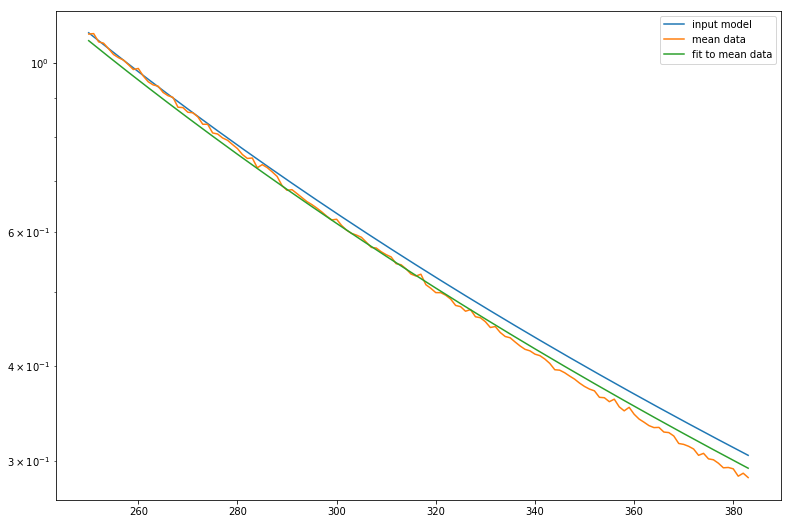

In [37]:
#only look at the high ell behaviour as this is the only place they seem to diverge
for i in range(len(freqs)):
    figure(figsize=(13,9))
    semilogy(ells[250:390], input_model[i][250:390], label='input model')
    semilogy(ells[250:390], PS_2d_const_mean[i][250:390], label='mean data')
    semilogy(ells[250:390], fit2[i][250:390], label='fit to mean data')
    legend();

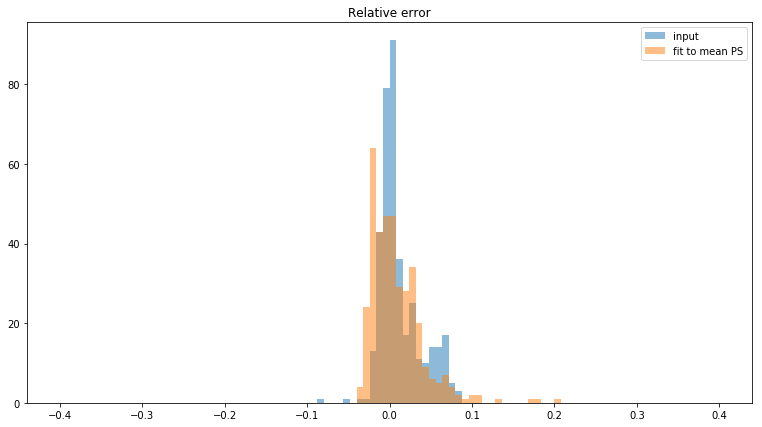

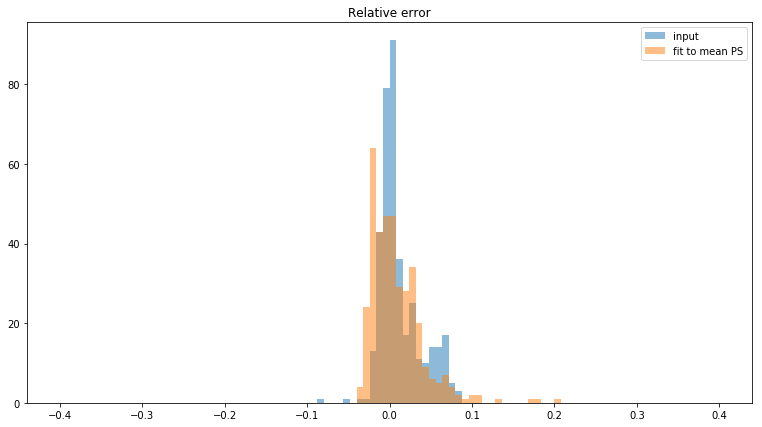

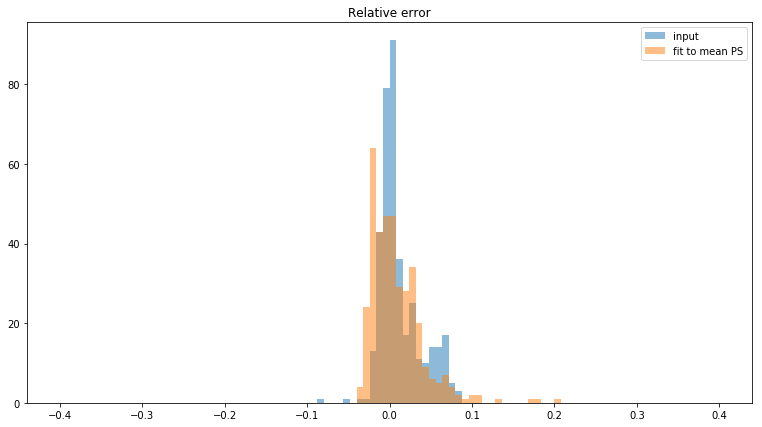

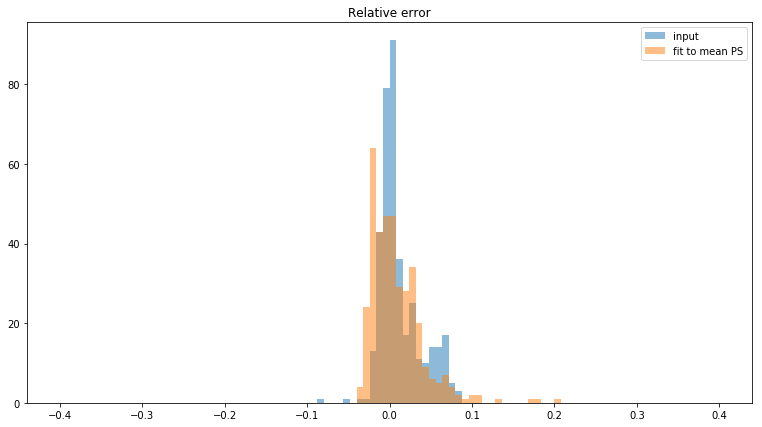

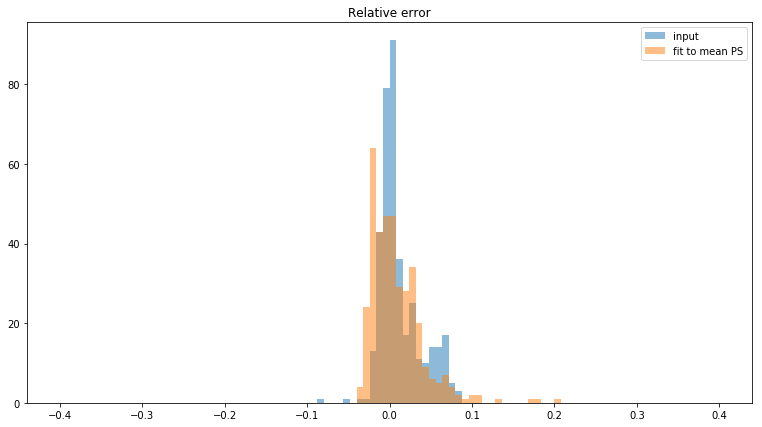

In [157]:
#plot histograms of the relative errors for these different fits
for i in range(len(freqs)):
    figure(figsize=(13,7))
    #input and data
    hist((input_model[i]-PS_2d_const_mean[i])/PS_2d_const_mean[i], label='input', alpha=0.5, bins=100,  range=(-0.4,0.4))
    #fit to realisation
#     hist((fit0[i]-PS_2d_const_mean[i])/PS_2d_const_mean[i], label='fit to realisation', alpha=0.5, bins=100, range=(-0.4,0.4))
    #fit to mean
    hist((fit2[i]-PS_2d_const_mean[i])/PS_2d_const_mean[i], label='fit to mean PS', alpha=0.5, bins=100, range=(-0.4,0.4))
    title('Relative error')
    legend()

In [38]:
#compare the actual chi2 values for these two fits

In [39]:
print(chi2_beta([A, alpha, beta], ells, freqs, PS_2d_const_mean))
print(chi2_beta([x2[0], x2[1], x2[2]], ells, freqs, PS_2d_const_mean))

426.1314775495412
158.54454735342597


In [40]:
#okay, so minimizer is indeed finding a smaller chi2

# okay, let's try a 1d fit to some data now using curve fit

In [41]:
#define some 1d data as just the 30 GHz data from before
PS_1d_const = PS_2d_const_mean[0]

In [84]:
#we want to fit the model auto0x0 to these data
#need to redefine the model to take ells as the first argument
def model_1d(ells, A, alpha):
    pcls = ff.powerlaw(ells, A, alpha)
    SED = ff.scale_synch(30e9, -3.2)
    mom0x0 = pcls * SED**2
    return mom0x0

In [85]:
params1d = [A, alpha]

In [86]:
opt_params, cov = curve_fit(model_1d, ells, PS_1d_const, p0=[1e3, -1])

In [87]:
print(opt_params)
print(np.sqrt(np.diag(cov)))

[2480.76378957   -2.89414757]
[7.27111440e+01 8.05390346e-03]


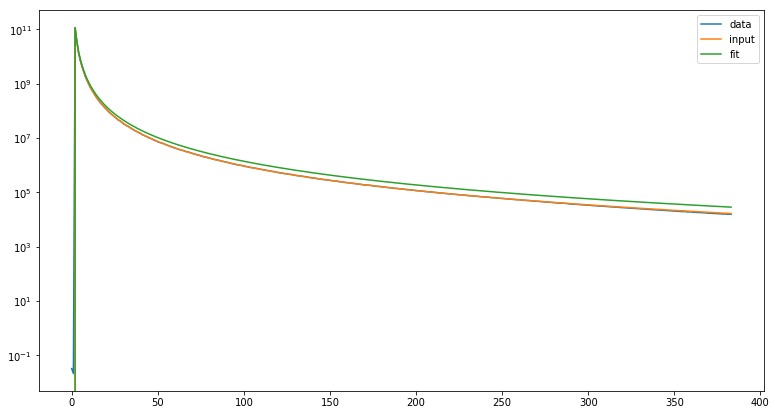

In [75]:
figure(figsize=(13,7))
semilogy(ells, PS_1d_const, label='data')
semilogy(ells, model_1d(ells, A, alpha), label='input')
semilogy(ells, model_1d(ells, opt_params[0], opt_params[1]), label='fit')
legend()

In [76]:
#hmmm why isn't this working?

In [180]:
amp_cls = ff.powerlaw(ells, A, alpha)

In [201]:
factor = 2*np.ones((3,384))

In [195]:
big_ones = np.ones((2,3,384))

In [202]:
factor = big_ones*factor

In [203]:
%autoreload

In [197]:
big_amp = big_ones*amp_cls
print(big_amp.shape)

(2, 3, 384)


In [198]:
big_amp = np.transpose(big_amp, (0,2,1))

In [199]:
big_amp.shape

(2, 384, 3)

In [200]:
big_amp[0].shape

(384, 3)

In [176]:
a = np.ones((2,3))
b = np.array([2,3,4])

In [177]:
c=b.T
print(b.shape)
print(c.shape)

(3,)
(3,)


In [179]:
print(a.shape, b.shape)
print(a*b)
# print(b*a)

(2, 3) (3,)
[[2. 3. 4.]
 [2. 3. 4.]]


In [142]:
print(a[0,1,0])
print(a[0,:,:])
print('')
print(a[:,0,:])
print('')
print(a[:,:,0])

0.0
[[2. 3.]
 [0. 0.]]

[[2. 3.]
 [2. 3.]]

[[2. 0.]
 [2. 0.]]


In [126]:
print(a)

[[[2. 3.]
  [2. 3.]]

 [[0. 0.]
  [0. 0.]]]


In [103]:
b

array([2, 3])

In [208]:
%autoreload

In [146]:
start=time.time()
ff.get_wigner_sum()
print(time.time()-start)

2.166853189468384


In [207]:
%lprun -f ff.get_wigner_sum ff.get_wigner_sum()

In [153]:
original = ff.get_wigner_sum()

In [209]:
new = ff.get_wigner_sum()

KeyboardInterrupt: 

In [205]:
print(new)

[2.90035222e+06 1.23169643e+06 1.32577240e+06 8.02952583e+05
 1.18132569e+06 8.07013908e+05 5.40334165e+05 3.74204217e+05
 2.69031438e+05 1.99953608e+05 1.52871295e+05 1.19698082e+05
 9.56404108e+04 7.77523896e+04 6.41607849e+04 5.36370148e+04
 4.53526969e+04 3.87353474e+04 3.33805360e+04 2.89968778e+04
 2.53706948e+04 2.23427774e+04 1.97927772e+04 1.76285211e+04
 1.57785658e+04 1.41869260e+04 1.28092856e+04 1.16102389e+04
 1.05612549e+04 9.63915923e+03 8.82498837e+03 8.10311744e+03
 7.46058916e+03 6.88659349e+03 6.37206065e+03 5.90934044e+03
 5.49194762e+03 5.11435857e+03 4.77184764e+03 4.46035479e+03
 4.17637785e+03 3.91688440e+03 3.67923926e+03 3.46114459e+03
 3.26059016e+03 3.07581186e+03 2.90525694e+03 2.74755482e+03
 2.60149240e+03 2.46599319e+03 2.34009952e+03 2.22295738e+03
 2.11380349e+03 2.01195409e+03 1.91679541e+03 1.82777533e+03
 1.74439627e+03 1.66620887e+03 1.59280667e+03 1.52382129e+03
 1.45891831e+03 1.39779366e+03 1.34017043e+03 1.28579602e+03
 1.23443968e+03 1.185890